<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./272_CEMS_GEFF_FWI_harmonized_danger_classes.ipynb"><< 272 - CEMS GEFF - Fire Weather Index - Harmonized Danger Classes</a>

<div class="alert alert-block alert-success">
<b>20 - DATA DISCOVERY</b></div>

<div class="alert alert-block alert-success">
<b>PREREQUISITE</b>

* **20 - DATA DISCOVERY**
 - [271 - CEMS GEFF - Fire Weather Index - Load and browse](./271_CEMS_GEFF_FWI_load_browse.ipynb)

It is recommended to go through the module before you start with this module.

</div>

<div class="alert alert-block alert-success">
<b>SEE ALSO</b>

* **20 - DATA DISCOVERY**
 - [272 - CEMS GEFF - Fire Weather Index - Harmonized Danger Classes](./272_CEMS_GEFF_FWI_harmonized_danger_classes.ipynb) 

</div>

<hr>

# 2.7.3 CEMS Global ECMWF Fire Forecasting (GEFF) - Fire Weather Index - Custom Danger Classes

Beside using harmonised danger classes, it is possible to use statistical methods to define critical danger levels for small areas, or even at the cell-size level. These methods are based on the definition of a local climatology. Some countries, like Italy and Portugal, tend to make use of locally calculated danger levels in addition to the harmonised ones suggested by EFFIS to get a feeling of how common the current fire weather is compared to the local climatology. This module shows how to compute local danger classes.

To assess the climatology of a given area, we are going to make use of the ERA5-based HRES reanalysis for a standard 30-year climate period: from 1981-01-01 to 2010-12-31.

For the purpose of this tutorial, the full reanalysis dataset can be retrieved from Zenodo. This dataset can be subsetted in time and space as already shown in module [2.7.1](./271_GEFF_fire_forecast_data_overview.ipynb).

#### Module overview
* [1 - Explore ERA5 HRES reanalysis data](#era5_explore)
* [2 - Calculate Regional Danger Levels](#regional_danger_levels)
* [3 - Maps of danger levels based on the daily fire climatology](#daily_climatology)

<hr>

#### Load required libraries

In [19]:
# Import the necessary libraries and enable inline displaying of plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)


<hr>

### <a id='era5_explore'></a>Explore `ERA5 HRE reanalysis` data

Open the `ERA5-based HRES reanalysis` data with xarray's function `xr.open_dataset` and select the `fwi` variable.

In [23]:
# Open reanalysis 1981-2010
ds = xr.open_dataset("../eodata/geff/greece/e5_hr/fwi_1981_2010_Attica.nc")
fwi = ds.fwi
fwi

<xarray.DataArray 'fwi' (time: 10957, lat: 7, lon: 7)>
[536893 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2010-12-31
  * lon      (lon) float32 23.06 23.34 23.62 23.91 24.19 24.47 24.75
  * lat      (lat) float32 38.92 38.64 38.36 38.08 37.8 37.52 37.24
Attributes:
    units:    -
    title:    Fire Weather Index

Let us briefly explore how the data looks like on a random summer day with xarray's `xr.plot` function.

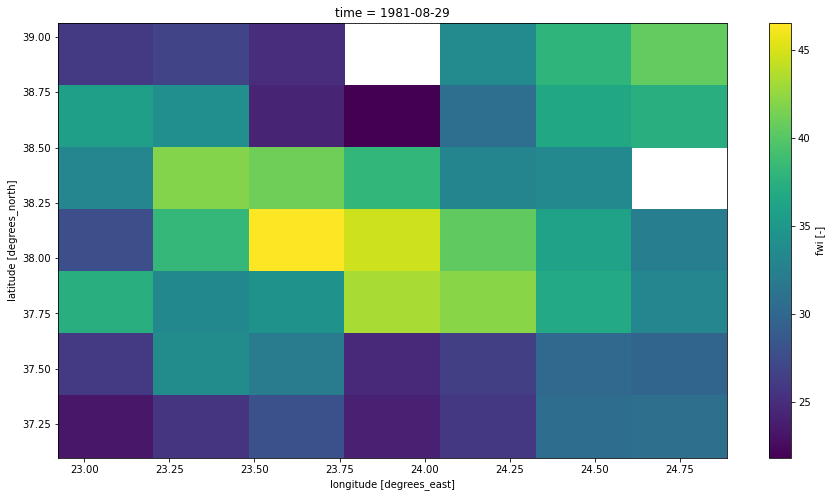

In [24]:
# Plot a layer in August (1981-08-29)
fwi[30*8,:,:].plot(figsize=(15,8));

Let us now calculate the mean value over the entire area for each days for the first 3 years. You can use xarray's function `xr.mean()` and average over the `lat` and `lon` dimensions.

In [25]:
fwi_mean = fwi[1:(3*365)].mean(dim = ('lon', 'lat'))

With the `xr.plot` function, you can visualize the daily mean value for the first three years (1981 to 1983).

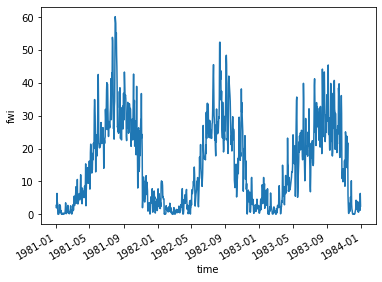

In [26]:
# Plot the mean value over a 3-year period
fwi_mean.plot();

As expected, the FWI values oscillate between 0 and 60 with highest values in summer. A data-driven way to derive danger thresholds makes use of percentiles. The set below usually corresponds to very low, low, moderate, high, very high and extreme danger: 

In a next step, we define percentile thresholds that can be mapped to fire danger classes.

In [27]:
fire_percentiles = [0.75, 0.85, 0.90, 0.95, 0.98]

### <a id='regional_danger_levels'></a>Calculate Regional Danger Levels

If the same thresholds have to be used throughout the year and for large areas, the percentiles can be simply calculated over the full time series record and then spatially averaged.

The function `xr.quantile` allows you to calculate the percentiles of the Fire Weather Index data. As quantile thresholds, you can use the `fire_percentiles` list defined above.

In [29]:
# Calculate the maps of percentiles as threshold of danger
danger_threshold_maps = fwi.quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)
danger_threshold_maps

<xarray.DataArray 'fwi' (quantile: 5, lat: 7, lon: 7)>
array([[[22.01203728, 20.54727745, 12.93248272,         nan,
         16.13629723, 19.01705742, 20.6427269 ],
        [29.58829117, 29.4538517 , 21.17814445, 17.20352364,
         17.11715889, 18.77209282, 21.48186302],
        [33.06942368, 36.67570877, 37.29034042, 39.085392  ,
         24.93300629, 20.4915657 ,         nan],
        [23.53962517, 35.25476074, 40.1220665 , 44.22527313,
         44.59788132, 35.42379379, 24.58705139],
        [33.90267944, 22.84484673, 23.94298553, 38.84714508,
         37.41917801, 28.83845711, 24.88023376],
        [26.38823318, 25.5965271 , 22.14639282, 22.26925659,
         23.01875114, 24.02263069, 25.10613823],
        [18.71719551, 19.46962547, 19.7369957 , 20.70085907,
         21.93692398, 24.13732719, 26.16820145]],

       [[28.83895149, 26.5305397 , 17.5088623 ,         nan,
         21.27133369, 25.25463524, 27.89098091],
        [37.42858582, 35.43976746, 26.14028969, 23.02967491,
         22.59467659, 25.81311531, 29.0777729 ],
        [39.36586304, 43.72062683, 43.94970932, 45.92550354,
...
         61.86018219, 53.80465775, 50.54163055],
        [37.77401505, 39.15653381, 39.24356232, 45.04935532,
         48.93574905, 50.21817474, 50.08211441],
        [31.83322563, 37.2517189 , 39.18647537, 42.71519699,
         45.83353271, 48.91825027, 50.97599411]],

       [[39.75818222, 39.14358826, 31.24244675,         nan,
         38.99463104, 45.38461899, 48.87516769],
        [53.0219751 , 47.51536194, 34.6541098 , 31.7356134 ,
         38.78905609, 46.48972153, 49.93404846],
        [55.90347046, 60.73663818, 58.74438568, 62.15751373,
         47.96117447, 46.05031982,         nan],
        [42.47328506, 60.24684158, 65.99165466, 73.12750427,
         71.71798615, 60.20734329, 51.91407455],
        [56.09676086, 42.88300461, 50.71122116, 73.92098938,
         70.80798492, 61.54605789, 58.63320053],
        [42.34291245, 44.24918167, 46.37893066, 54.55547211,
         58.10035385, 58.36240829, 57.76958115],
        [38.63470306, 45.02319626, 47.45938583, 51.96191223,
         54.95136978, 56.64276321, 57.9082164 ]]])
Coordinates:
  * lon       (lon) float32 23.06 23.34 23.62 23.91 24.19 24.47 24.75
  * lat       (lat) float32 38.92 38.64 38.36 38.08 37.8 37.52 37.24
  * quantile  (quantile) float64 0.75 0.85 0.9 0.95 0.98
Attributes:
    units:    -
    title:    Fire Weather Index

You can then plot the danger threshold map for e.g. the 90th percentile (high danger). By changing the index, you can see plot the map for each percentile defined.

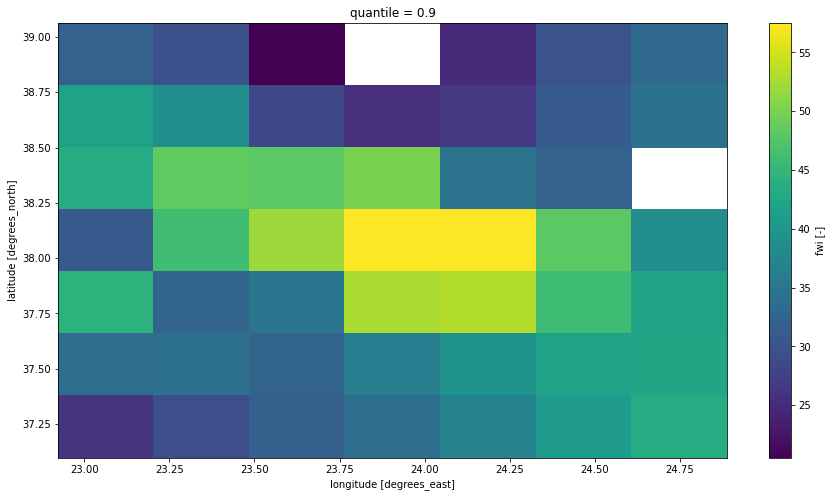

In [35]:

# Plot the map corresponding to the 90th percentile = high danger
danger_threshold_maps[2].plot(figsize=(15,8));

Subsequently, you can calculate the median over the area for each time step. You can use the function `xr.median` to calculate the median across the specified dimension(s). 

In [10]:
danger_threshold_maps.median(dim=('lon', 'lat')).round(0)

<xarray.DataArray 'fwi' (quantile: 5)>
array([24., 31., 36., 43., 52.])
Coordinates:
  * quantile  (quantile) float64 0.75 0.85 0.9 0.95 0.98

Defined thresholds are the following:
* `<24` - very low
* `24-31` - low
* `31-36` - moderate
* `36-43` - high
* `43-52` - very high
* `>52` - extreme

This approach generally tends to underestimate danger levels because the sample contains many low values occurring during autumn and winter months. As an alternative, one could only consider records during the fire season (if known in advance). Let's assume the fire season in Attica goes from June to August (JJA):

In [37]:
# Find indices corresponding to JJA
idx = np.concatenate(np.where((fwi.time.dt.month >= 6)  & (fwi.time.dt.month <= 8)))
idx

array([  151,   152,   153, ..., 10832, 10833, 10834])

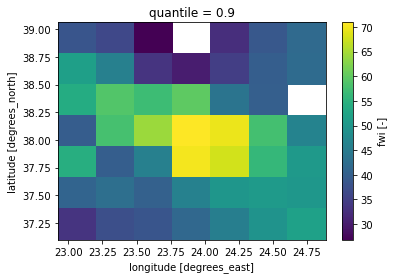

In [38]:
# Calculate quantiles only over JJA
danger_threshold_maps_JJA = fwi[idx,:,:].quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)

# Plot the map corresponding to the 90th percentile = high danger
danger_threshold_maps_JJA[2].plot();

Obtain fixed set of thresholds as the median over the area for each time step:

In [39]:
danger_threshold_maps_JJA.median(dim=('lon', 'lat')).round(0)

<xarray.DataArray 'fwi' (quantile: 5)>
array([36., 41., 46., 50., 56.])
Coordinates:
  * quantile  (quantile) float64 0.75 0.85 0.9 0.95 0.98

Defined thresholds are the following:
* `<36` - very low
* `36-41` - low
* `41-46` - moderate
* `46-50` - high
* `50-56` - very high
* `>56` - extreme


This approach relies on the a-priori estimate of the length of the fire season, which is not always trivial. Also, spatial averaging over large regions should be avoided (if possible) to remove smoothing effects.

These thresholds are much higher than the EFFIS ones. How would the re-classified forecast look like using these local thresholds?

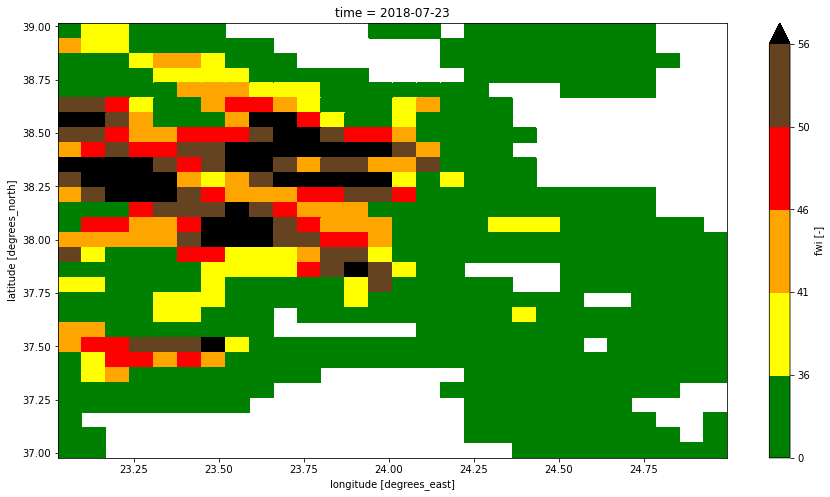

In [36]:
# Open raw RT HRES forecast for Attica (Greece), issued on 14th July 2018 (10 days before the Attica fires)
fct = xr.open_dataset("../eodata/geff/greece/rt_hr/ECMWF_FWI_20180714_1200_hr_fwi_rt.nc")

# Plot the re-classified forecast, Day 10
fct.fwi[9].plot(levels = [0, 36.0, 41.0, 46.0, 50.0, 56.0],
                colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
                label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme'],
               figsize=(15,8));

### <a id='daily_climatology'></a>Maps of danger levels based on the daily fire climatology

More often, local authorities estimate statistical thresholds based on the daily climatology on a cell-by-cell basis. The thresholds are delivered in the form of a map, which allows to avoid any smoothing effect due to spatial averaging. 
To understand how this works, let's assume we want to estimate danger level maps for 10th July 2018.

In [40]:
# Find indices of dates corresponding to 23rd July
idx = np.concatenate(np.where((fwi.time.dt.day == 23) & (fwi.time.dt.month == 7)))
idx

array([  203,   568,   933,  1299,  1664,  2029,  2394,  2760,  3125,
        3490,  3855,  4221,  4586,  4951,  5316,  5682,  6047,  6412,
        6777,  7143,  7508,  7873,  8238,  8604,  8969,  9334,  9699,
       10065, 10430, 10795])

Let's expand this range of indices to include 4 days before and after each date and concatenate all the indices in a one-dimensional array.

In [41]:
indices_list = []
for i in idx:
    indices_list.append(list(range(i - 4, i + 4 + 1)))
    
# Concatenate all the indices in a 1-dimensional array
indices = np.concatenate(indices_list)
indices

array([  199,   200,   201,   202,   203,   204,   205,   206,   207,
         564,   565,   566,   567,   568,   569,   570,   571,   572,
         929,   930,   931,   932,   933,   934,   935,   936,   937,
        1295,  1296,  1297,  1298,  1299,  1300,  1301,  1302,  1303,
        1660,  1661,  1662,  1663,  1664,  1665,  1666,  1667,  1668,
        2025,  2026,  2027,  2028,  2029,  2030,  2031,  2032,  2033,
        2390,  2391,  2392,  2393,  2394,  2395,  2396,  2397,  2398,
        2756,  2757,  2758,  2759,  2760,  2761,  2762,  2763,  2764,
        3121,  3122,  3123,  3124,  3125,  3126,  3127,  3128,  3129,
        3486,  3487,  3488,  3489,  3490,  3491,  3492,  3493,  3494,
        3851,  3852,  3853,  3854,  3855,  3856,  3857,  3858,  3859,
        4217,  4218,  4219,  4220,  4221,  4222,  4223,  4224,  4225,
        4582,  4583,  4584,  4585,  4586,  4587,  4588,  4589,  4590,
        4947,  4948,  4949,  4950,  4951,  4952,  4953,  4954,  4955,
        5312,  5313,

Calculate the maps of percentiles as threshold of danger. First subset the `FWI` data based on the indices identified and then calculate the percentiles with the function `xr.quantile`.

In [44]:
# Calculate the maps of percentiles as threshold of danger
fwi10July = fwi[indices,:,:]
daily_danger_threshold_maps = fwi10July.quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)
daily_danger_threshold_maps

<xarray.DataArray 'fwi' (quantile: 5, lat: 7, lon: 7)>
array([[[37.00189209, 34.37077713, 24.0179925 ,         nan,
         30.83782005, 37.02260208, 39.08701897],
        [49.29198456, 44.11609936, 31.99301243, 28.37241554,
         33.04329872, 36.88964939, 40.04838467],
        [50.91664124, 56.74479008, 54.88561058, 58.10211754,
         41.29185581, 38.11110115,         nan],
        [37.50442696, 54.89251995, 62.00637245, 69.52206993,
         68.53139877, 57.29836082, 44.52624035],
        [51.29334927, 38.14374352, 42.32217598, 66.61370468,
         65.93598747, 55.01241875, 47.74883175],
        [39.54702091, 41.04331493, 37.08908176, 42.1903801 ,
         47.21703625, 48.07499981, 48.47241783],
        [31.26529408, 34.34714794, 34.32701683, 37.37602329,
         42.9844408 , 47.75570393, 49.34843349]],

       [[39.02740402, 37.73542233, 28.89248285,         nan,
         34.9441927 , 40.55572052, 43.25259151],
        [51.90572662, 46.8878706 , 33.82621632, 30.27553396,
         37.22504158, 42.13829899, 44.24623146],
        [55.01319218, 60.09077473, 58.14372768, 61.09407539,
...
         79.34842415, 66.07428246, 59.80414219],
        [47.25788269, 48.73670177, 47.71361408, 56.26866817,
         59.62187023, 59.22334595, 58.19717445],
        [43.2366478 , 46.51934662, 46.54162426, 51.36513367,
         55.7721674 , 57.22407894, 59.20071049]],

       [[47.91904816, 49.62021423, 40.76430115,         nan,
         46.50965736, 51.28788231, 55.30795715],
        [61.9661525 , 56.24203316, 40.23673218, 36.93172646,
         46.11237274, 54.2761882 , 56.87868721],
        [68.22218277, 69.87907608, 67.45629211, 69.4577533 ,
         57.74736534, 54.6733902 ,         nan],
        [52.03714981, 72.42542664, 75.06366516, 81.60610214,
         79.31897919, 71.35181412, 60.20583061],
        [65.55296616, 50.69865929, 59.82787148, 86.35865189,
         82.7143013 , 70.55669067, 66.41532639],
        [48.60441025, 50.45587547, 50.58817192, 60.1617952 ,
         64.024217  , 62.88389748, 65.77249039],
        [45.90098984, 49.5186821 , 49.78816055, 54.2698455 ,
         59.09899506, 61.10455513, 64.50565475]]])
Coordinates:
  * lon       (lon) float32 23.06 23.34 23.62 23.91 24.19 24.47 24.75
  * lat       (lat) float32 38.92 38.64 38.36 38.08 37.8 37.52 37.24
  * quantile  (quantile) float64 0.75 0.85 0.9 0.95 0.98
Attributes:
    units:    -
    title:    Fire Weather Index

Now, plot the map of daily climatological 90th percentile as threshold of high danger (90th percentile).

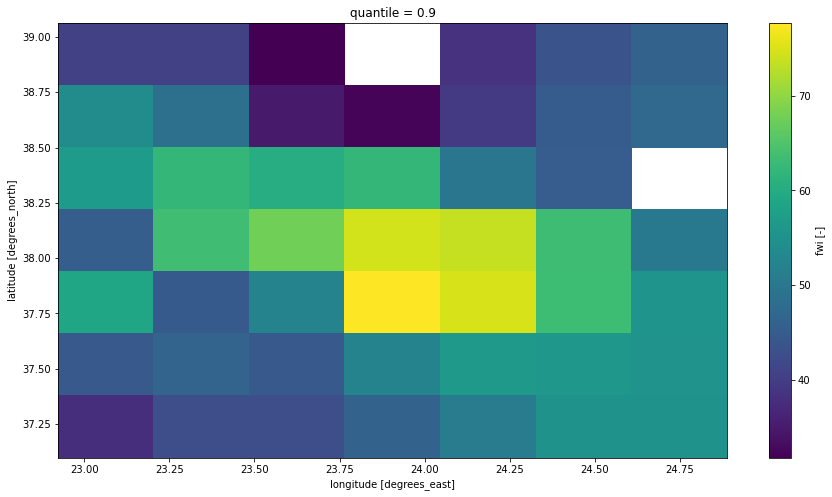

In [45]:
daily_danger_threshold_maps[2].plot(figsize=(15,8));

This map is very similar to the one calculated previously, which means that the fire weather in Attica does not vary much over the fire season.

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./272_CEMS_GEFF_FWI_harmonized_danger_classes.ipynb"><< 272 - CEMS GEFF - Fire Weather Index - Harmonized Danger Classes</a>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>